In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [32]:
results_tjerk = pd.read_csv("exp_results_Tjerk.csv")
results_rob = pd.read_csv("exp_results_rob.csv")
results_felix = pd.read_csv("exp_results_felix.csv")

In [33]:
class visualize_experiment:
    """
    Class designed to visualize the difference between MySQL and NoSQL axcquired from experiments
    """
        
    def __init__(self, df1, df2, df3):
        # Define class variables
        self.df1 = df1
        self.df2 = df2
        self.df3 = df3
        
    def prepare_dataframe(self, df):
        """
        This function returns a dataframe
        """
        # Group the query results by person/data_set/data_store/data_size/query
        # and calculate the mean of the trials
        grouped_results = pd.DataFrame(df.groupby(by = ["person", "data_set", "data_store", "data_size", "query"]).mean()["response_time"])
        grouped_results = grouped_results.reset_index()
        
        # Rename response time column based on the data_store
        document_results = grouped_results[grouped_results["data_store"] == "document"]
        document_results = document_results.rename(columns = {"response_time": "MongoDB"})  
        document_results = document_results.drop(columns = ["data_store"])
        
        relational_results = grouped_results[grouped_results["data_store"] == "relational"]
        relational_results = relational_results.rename(columns = {"response_time": "PostgreSQL"})
        relational_results = relational_results.drop(columns = ["data_store"])
        
        # Merge the relational and document results
        combined_results = document_results.merge(relational_results, on = ["person", "data_set", "data_size", "query"], how = "inner")

        return combined_results
    
    def select_numerical_columns(self, prepared_df):
        """
        This functions selects the response times of the different data_stores
        """
        return self.prepare_dataframe(prepared_df).loc[:, ['MongoDB', 'PostgreSQL']]
    
    def average_of_experiments(self):
        "This function returns the average of the 3 performed experiments"
        # Select response time columns for average calculation
        experiment_1 = self.select_numerical_columns(self.df1)
        experiment_2 = self.select_numerical_columns(self.df2)
        experiment_3 = self.select_numerical_columns(self.df3)
        
        # Calculate the average of the experiments
        average_experiments = (experiment_1 + experiment_2 + experiment_3) / 3
        
        # Assign averages to dataframe
        self.prepare_dataframe(self.df1)[['MongoDB', 'PostgreSQL']] = average_experiments
        return self.prepare_dataframe(self.df1)
    
    def assign_query_to_hypthesis(self, average_df, h1_queries, h2_queries):
        """
        This function returns results based on the different queries
        """
        results_h1 = average_df[average_df["query"].isin(h1_queries)]
        results_h2 = average_df[average_df["query"].isin(h2_queries)]
        results_import = average_df[average_df["query"] == "import"]
        return results_h1, results_h2, results_import
    
    def acquire_final_dataframe(self, dataset, average_df, h1_queries, h2_queries):
        """
        This function spilts the dataframe based on the data store type
        """
        final_data = self.assign_query_to_hypthesis(average_df, h1_queries, h2_queries)
        
        final_data_h1 = final_data[0][final_data[0]['data_set'] == dataset]
        final_data_h2 = final_data[1][final_data[1]['data_set'] == dataset]
        final_data_import = final_data[2][final_data[2]['data_set'] == dataset]
        
        final_data_h1['query'] = final_data_h1['query'].astype(int)
        final_data_h2['query'] = final_data_h2['query'].astype(int)

        return final_data_h1, final_data_h2, final_data_import

    def visualize_barplots(self, data, plot_type, data_store):
        """
        This function visualizes the experiment results
        """
        if plot_type == 'bar':
            fig, ax = plt.subplots(1, 5, figsize=(20,3))

            for i, size in enumerate(data["data_size"].unique()):

                temp_df = data[data["data_size"] == size].sort_values(by = "query")
                temp_df.plot.bar(x = "query", y = ["MongoDB", "PostgreSQL"], ax = ax[i], title = f"Response time with datasize {size}")
           
        if plot_type == 'line':
            data.plot(kind = "line", x = "data_size", y = ["MongoDB","PostgreSQL"], title = f"Time to import data in MS - {data_store} Dataset") 
            
    def visualize_scalability(self, data, data_store):
        """This function plots the scalability of the different queries"""
        fig, ax = plt.subplots(1, len(data['query'].unique()), figsize=(20,3))

        for i, query in enumerate(data["query"].unique()):
            temp_df = data[data["query"] == query]
            temp_df.plot.line(x = "data_size", y = ["MongoDB", "PostgreSQL"], ax = ax[i], title = f"Scalability query : {query}")
            
    def prepare_os_data(self, tjerk, rob, felix, queries, data_set, data_size):
        """
        This function prepares the data for the operation systems performance plot
        """ 
        tjerk_data = self.prepare_dataframe(tjerk)
        tjerk_data = tjerk_data[(tjerk_data['data_set'] == data_set) & (tjerk_data['data_size'] == data_size)]
        tjerk_data = tjerk_data[tjerk_data['query'].isin(queries)]
        
        felix_data = self.prepare_dataframe(felix)
        felix_data = felix_data[(felix_data['data_set'] == data_set) & (felix_data['data_size'] == data_size)]
        felix_data = felix_data[felix_data['query'].isin(queries)]
        
        rob_data = self.prepare_dataframe(rob)
        rob_data = rob_data[(rob_data['data_set'] == data_set) & (rob_data['data_size'] == data_size)]
        rob_data = rob_data[rob_data['query'].isin(queries)]
        
        return pd.concat([tjerk_data, felix_data, rob_data])
    
    def list_query(self, person, data_structure, joined_df):
        """
        This function gets the desired input for the visualisation, this ensure that any number of 
        query can be added quickly to the visualization
        """
        return joined_df[joined_df['person'] == person][data_structure].tolist()
    
    def visualize_os_performance(self, joined_df, data_structure, plot_title):
        """
        This function visualizes the performance of the different operating systems
        """
        queries_tjerk = self.list_query('Tjerk', data_structure, joined_df)
        queries_felix = self.list_query('felix', data_structure, joined_df)
        queries_rob =  self.list_query('rob', data_structure, joined_df)
        
        queries = sorted([int(x) for x in joined_df['query'].unique()])
        
        df = pd.DataFrame(np.c_[queries_tjerk, queries_felix, queries_rob], index = queries)
        df.plot.bar()
        plt.legend(['Windows', 'MacOS', 'Ubuntu'])
        plt.title(plot_title)

***Cell for the OS performance***
- Make sure that the dataset corresponds with a right data size

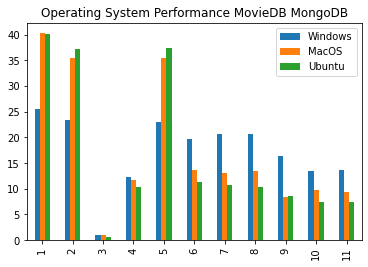

In [34]:
setup = visualize_experiment(results_tjerk, results_rob, results_felix)
joined_data = setup.prepare_os_data(results_tjerk, results_rob, results_felix, ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'], 'movies_db', 23000)
setup.visualize_os_performance(joined_data, 'MongoDB', 'Operating System Performance MovieDB MongoDB')

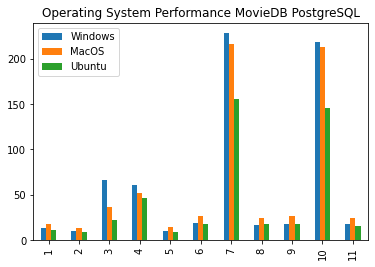

In [35]:
setup = visualize_experiment(results_tjerk, results_rob, results_felix)
joined_data = setup.prepare_os_data(results_tjerk, results_rob, results_felix, ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'], 'movies_db', 23000)
setup.visualize_os_performance(joined_data, 'PostgreSQL', 'Operating System Performance MovieDB PostgreSQL')

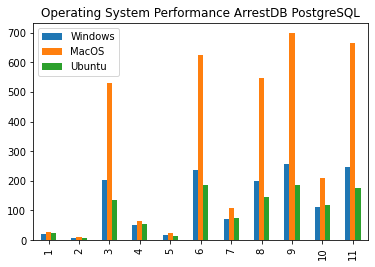

In [36]:
setup = visualize_experiment(results_tjerk, results_rob, results_felix)
joined_data = setup.prepare_os_data(results_tjerk, results_rob, results_felix, ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'], 'arrest_db', 50000)
setup.visualize_os_performance(joined_data, 'PostgreSQL', 'Operating System Performance ArrestDB PostgreSQL')

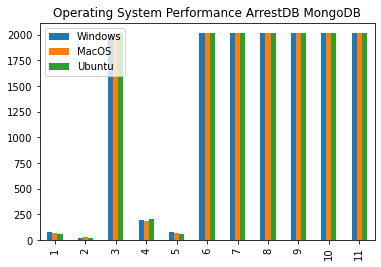

In [37]:
setup = visualize_experiment(results_tjerk, results_rob, results_felix)
joined_data = setup.prepare_os_data(results_tjerk, results_rob, results_felix, ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'], 'arrest_db', 50000)
setup.visualize_os_performance(joined_data, 'MongoDB', 'Operating System Performance ArrestDB MongoDB')

***Cell for the other visualizations***

<ipython-input-33-c790c57b5379>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data_h1['query'] = final_data_h1['query'].astype(int)
<ipython-input-33-c790c57b5379>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data_h2['query'] = final_data_h2['query'].astype(int)


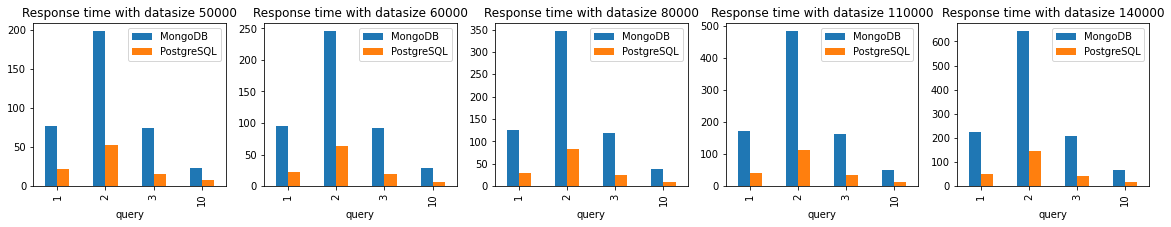

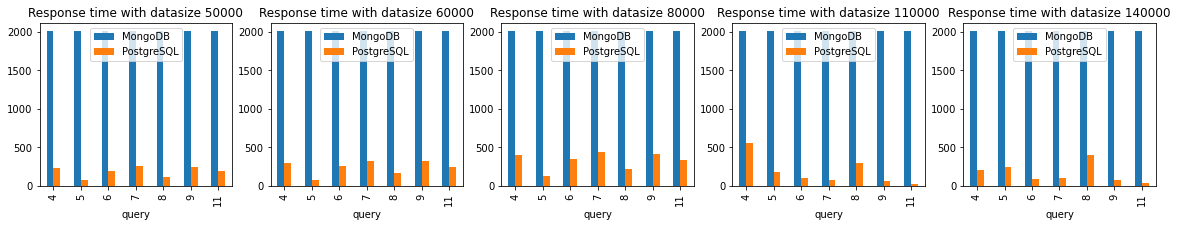

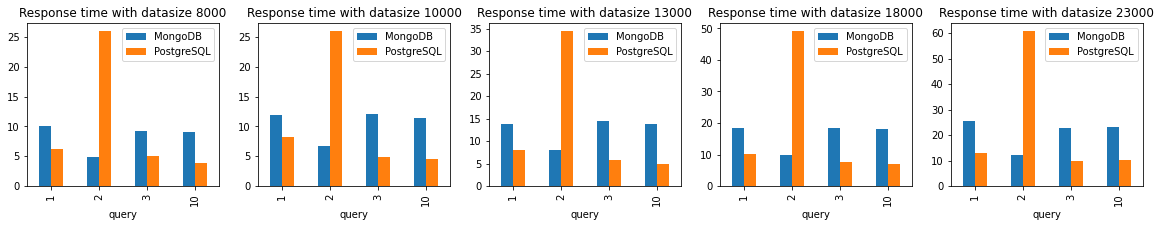

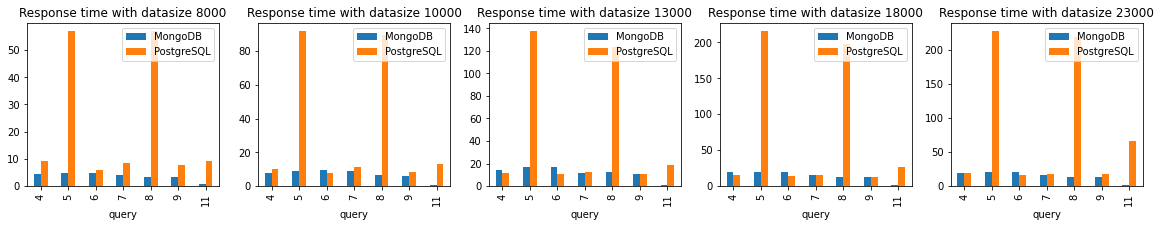

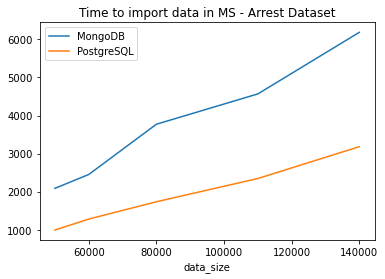

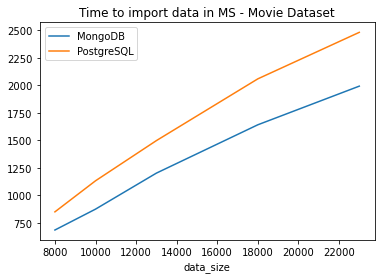

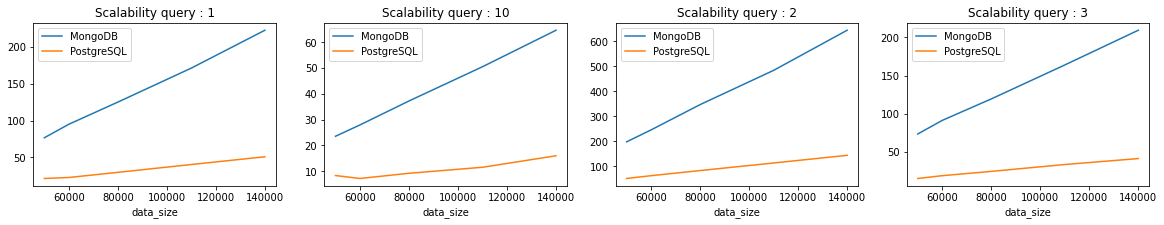

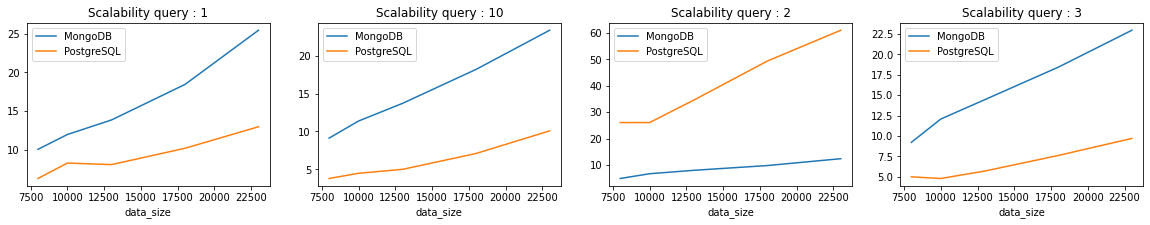

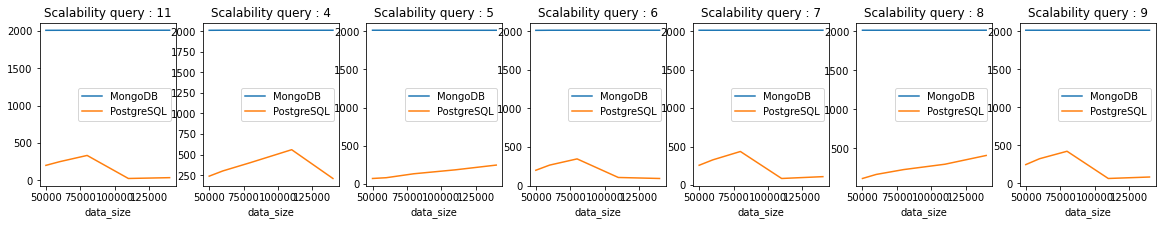

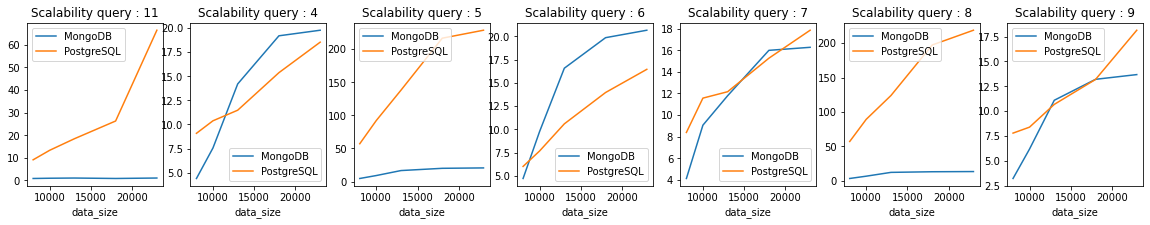

In [38]:
# Insert experiment results into class
setup = visualize_experiment(results_tjerk, results_rob, results_felix)

# Acquire arrest and movie dataframes
final_data_arrest = setup.acquire_final_dataframe('arrest_db', setup.average_of_experiments(), ["1","2", "3","10"], ["4", "5", "6", "7", "8", "9", "11"])
final_data_movie = setup.acquire_final_dataframe('movies_db', setup.average_of_experiments(), ["1","2", "3","10"], ["4", "5", "6", "7", "8", "9", "11"])

# Visualize bar charts h1, h2 and import
h1_arrest = setup.visualize_barplots(final_data_arrest[0], 'bar', 'Arrest')
h2_arrest = setup.visualize_barplots(final_data_arrest[1], 'bar', 'Arrest')
h1_movies = setup.visualize_barplots(final_data_movie[0], 'bar', 'Movie')
h2_movies = setup.visualize_barplots(final_data_movie[1], 'bar', 'Movie')

# Visualize import time in a line chart
import_movies = setup.visualize_barplots(final_data_arrest[2], 'line', 'Arrest')
import_arrest = setup.visualize_barplots(final_data_movie[2], 'line', 'Movie')

# Visualize scalability
h1_scalability_arrest = setup.visualize_scalability(final_data_arrest[0], 'arrest')
h1_scalability_movie = setup.visualize_scalability(final_data_movie[0], 'movie')
h2_scalability_arrest = setup.visualize_scalability(final_data_arrest[1], 'arrest')
h2_scalability_movie = setup.visualize_scalability(final_data_movie[1], 'movie')